In [361]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from IPython.core.pylabtools import figsize
from torch.distributions import Normal

In [362]:
# class Flow(nn.Module):
#     def __init__(self):
#         super().__init__()
#         tanh = nn.Tanh()
#         self.f = lambda z0: 10 * tanh(z0)
#         self.f_derivative = lambda z0: 10 * (1 - tanh(z0) ** 2)
#         pass
#
#     def forward(self, z0):
#         deriv = self.f_derivative(z0)  # (10000, 2)
#         det = deriv[:, 0] * deriv[:, 1]  # (10000, 1)
#         return self.f(z0), det

class Flow(nn.Module):
    def __init__(self):
        super().__init__()
        self.u = torch.Tensor([-3, 1])
        self.w = torch.Tensor([-1, 5])
        self.b = torch.Tensor([1])
        self.h = nn.Tanh()
        self.h_derivative = lambda x: 1 - self.h(x) ** 2
        # self.f = lambda z0: z0 + u @ self.h(self.w)
        # self.f_derivative = lambda z0: 10 * (1 - tanh(z0) ** 2)
        pass

    def constrained_u(self):
        """
        Constrain the parameters u to ensure invertibility
        """
        wu = torch.matmul(self.w.t(), self.u)
        m = lambda x: -1 + torch.log(1 + torch.exp(x))
        return self.u + (m(wu) - wu) * (self.w / (torch.norm(self.w) ** 2 + 1e-15))

    def forward(self, z0):
        u = self.constrained_u()
        # z = (batch_size, 2)
        # (batch_size, 2) @ (2, 1) + (1,) = (batch_size, 1)
        linear_transformed = z0 @ self.w + self.b  # (batch_size, )
        # (batch_size , 1) @ (1, 2) = (batch_size, 2)
        non_linear_transformed = self.h(linear_transformed).unsqueeze(1) @ u.unsqueeze(0)
        return z0 + non_linear_transformed

    def det(self, z0):
        # 流模型偏导数雅可比矩阵的行列式 Eq. (12) det |∂f(z)/∂z|
        u = self.constrained_u()
        # z = (batch_size, 2) @ w = (2,) -> (batch_size, 1) @ w.unsqueeze(0) = (1, 2) -> (batch_size, 2)
        psi_z = self.h_derivative(z0 @ self.w + self.b).unsqueeze(1)  @ self.w.unsqueeze(0) # (batch_size, 2)
        return torch.abs(1 + psi_z @ u)


def log_gaussian_pdf(z):
    # z = (batch_size, 2)
    # gaussian = Normal(loc=[0,0], scale=[1,1])
    # pdf = gaussian.log_prob(z[:, 0]) + gaussian.log_prob(z[:, 1])
    return -.5 * (torch.log(torch.tensor([math.pi * 2], device=z.device) + 1e-15) + z ** 2).sum(1)


def gen_meshgrid_z(lims = np.array([[-5, 5], [-5, 5]]), nb_point_per_dimension=100):
    latent_space_boundaries = np.array([[lims[0][0], lims[0][1]], [lims[1][0], lims[1][1]]]);
    xx, yy = np.meshgrid(
        np.linspace(latent_space_boundaries[0][0], latent_space_boundaries[0][1], nb_point_per_dimension),
        np.linspace(latent_space_boundaries[1][0], latent_space_boundaries[1][1], nb_point_per_dimension))
    # 在二维特征空间[-15, 15], [-15, 15]上所有的网格点 (10000, 2)
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1), dtype=torch.float)

    return z


def plot_gaussian_density(lims = np.array([[-5, 5], [-5, 5]]), nb_point_per_dimension=100):
    z = gen_meshgrid_z(nb_point_per_dimension=nb_point_per_dimension)

    p_z_values = torch.exp(log_gaussian_pdf(z))  # (10000, 1)
    p_z_values = p_z_values.reshape(nb_point_per_dimension, nb_point_per_dimension).detach().numpy()  # (100, 100)

    plt.pcolormesh(z[:,0].reshape(nb_point_per_dimension, nb_point_per_dimension),
                   z[:,1].reshape(nb_point_per_dimension, nb_point_per_dimension),
                   p_z_values.reshape(nb_point_per_dimension, nb_point_per_dimension)
                   , cmap="coolwarm"
                   )

    plt.colorbar()

    # plt.show()

    pass


def plot_flow_density(flow, lims = np.array([[-5, 5], [-5, 5]]),nb_point_per_dimension=100):
    z0 = gen_meshgrid_z(nb_point_per_dimension=nb_point_per_dimension)
    z1, det = flow.forward(z0), flow.det(z0)

    z1 = z1.detach().numpy()  # (10000, 2)

    z1_pdf = torch.exp(log_gaussian_pdf(z0)) * (1 / det)  # (10000, 1)

    plt.pcolormesh(z1[:,0].reshape(nb_point_per_dimension, nb_point_per_dimension),
                   z1[:,1].reshape(nb_point_per_dimension, nb_point_per_dimension),
                   z1_pdf.reshape(nb_point_per_dimension, nb_point_per_dimension)
                   , cmap="coolwarm"
                   )

    plt.colorbar()

    plt.xlim(lims[0][0],lims[0][1])
    plt.ylim(lims[1][0],lims[1][1])

    # plt.show()


def plot_gaussian_samples(lims = np.array([[-4, 4], [-4, 4]]), nb_samples=100):
    loc = torch.tensor([0,0], dtype=torch.float32)
    scale = torch.tensor([1,1], dtype=torch.float32)
    q_z0 = Normal(loc=loc, scale=scale)

    for s in range(nb_samples):
        z0 = q_z0.rsample().unsqueeze(0)  # (1, 2)
        plt.scatter(z0[:,0], z0[:,1], color = 'red', alpha=0.5)

    plt.xlim(lims[0][0],lims[0][1])
    plt.ylim(lims[1][0],lims[1][1])

    # plt.show()


def plot_flow_samples(flow, lims = np.array([[-5, 5], [-5, 5]]), nb_samples=100):
    loc = torch.tensor([0,0], dtype=torch.float32)
    scale = torch.tensor([1,1], dtype=torch.float32)
    q_z0 = Normal(loc=loc, scale=scale)

    for s in range(nb_samples):
        z0 = q_z0.rsample().unsqueeze(0)  # (1, 2)
        z1 = flow(z0)
        plt.scatter(z1[:,0], z1[:,1], color = 'red', alpha=0.5)

    plt.xlim(lims[0][0],lims[0][1])
    plt.ylim(lims[1][0],lims[1][1])

    # plt.show()

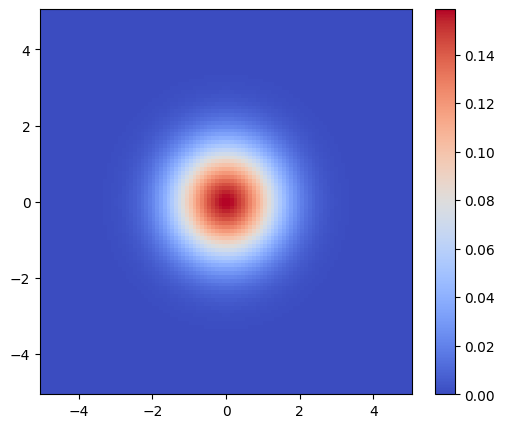

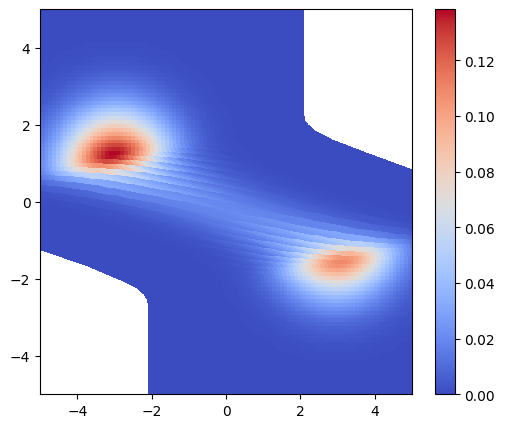

In [363]:
plt.figure(figsize=(6,5))
plot_gaussian_density()
plt.savefig(f'figs/fig1(a).jpg', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=(6,5))
flow = Flow()
plot_flow_density(flow)
plt.savefig(f'figs/fig1(b).jpg', bbox_inches='tight', dpi=300)

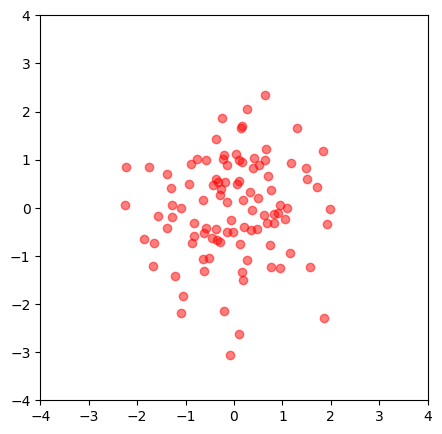

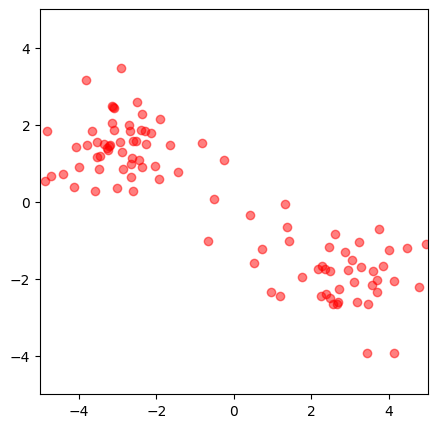

In [364]:
plt.figure(figsize=(5,5))
plot_gaussian_samples()
plt.savefig(f'figs/fig2(a).jpg', bbox_inches='tight', dpi=300)

plt.figure(figsize=(5,5))
plot_flow_samples(flow)
plt.savefig(f'figs/fig2(b).jpg', bbox_inches='tight', dpi=300)